### Okay, Let's make sense of the features!
---

Some thoughts:
* Use shap to study behaviors
* Generate trend with WOE or simple lin reg
* Match whether they measure up
* If not, is there a reason for it?
    * Lime?
    * Look at local data points
    * Interaction effects?

In [1]:
import sys, os
sys.path.insert(1, '../..')
import pandas as pd
import numpy as np
import pickle as pkl
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import rdsutils.plot as rdsplot
import shap, math
from tqdm import tqdm


# feature preprocessing, if needed
from train import preprocess

plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

#### Load Data and Model
---

In [2]:
modeling_df = pd.read_feather("../../artifacts/modeling_df_final_with_oof_preds_replication.feather")
modeling_df = preprocess(modeling_df)
modeling_df.shape

(1086183, 48)

<AxesSubplot:>

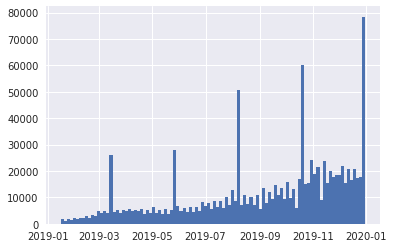

In [3]:
modeling_df.sample_date.hist(bins=100)

In [4]:
# get scores
model = pkl.load(open('../../models/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb'))

### SHAP
---

In [5]:
%%time 

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(modeling_df[model.feature_name_])[1]

# if we use probability option: more interpretable, more time consuming
# explainer = shap.TreeExplainer(model, data=sample, model_output=model_output)  ## probability
# shap_values = explainer.shap_values(modeling_df[model.feature_name_])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


CPU times: user 1h 22min 18s, sys: 864 ms, total: 1h 22min 19s
Wall time: 5min 19s


In [6]:
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_shap_dependence(df, shap_values, features, ncols=6, figsize=None, **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for feature, ax in zip(features, axs.flatten()):
        shap.dependence_plot(feature, shap_values, df, 
                             ax=ax, show=False, **kwargs)
        rlim = df[feature].quantile(0.98)
        llim = df[feature].quantile(0.02) - ((rlim - df[feature].quantile(0.02)) / 12)
            
        if rlim < np.inf and llim > -np.inf:
            ax.set_xlim(left=llim, right=rlim)
        
    return fig

In [7]:
# sort features by importance
fimp = sorted(zip(model.feature_importances_, model.feature_name_), reverse=True)
features_by_imp = list(list(zip(*fimp))[1])

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.


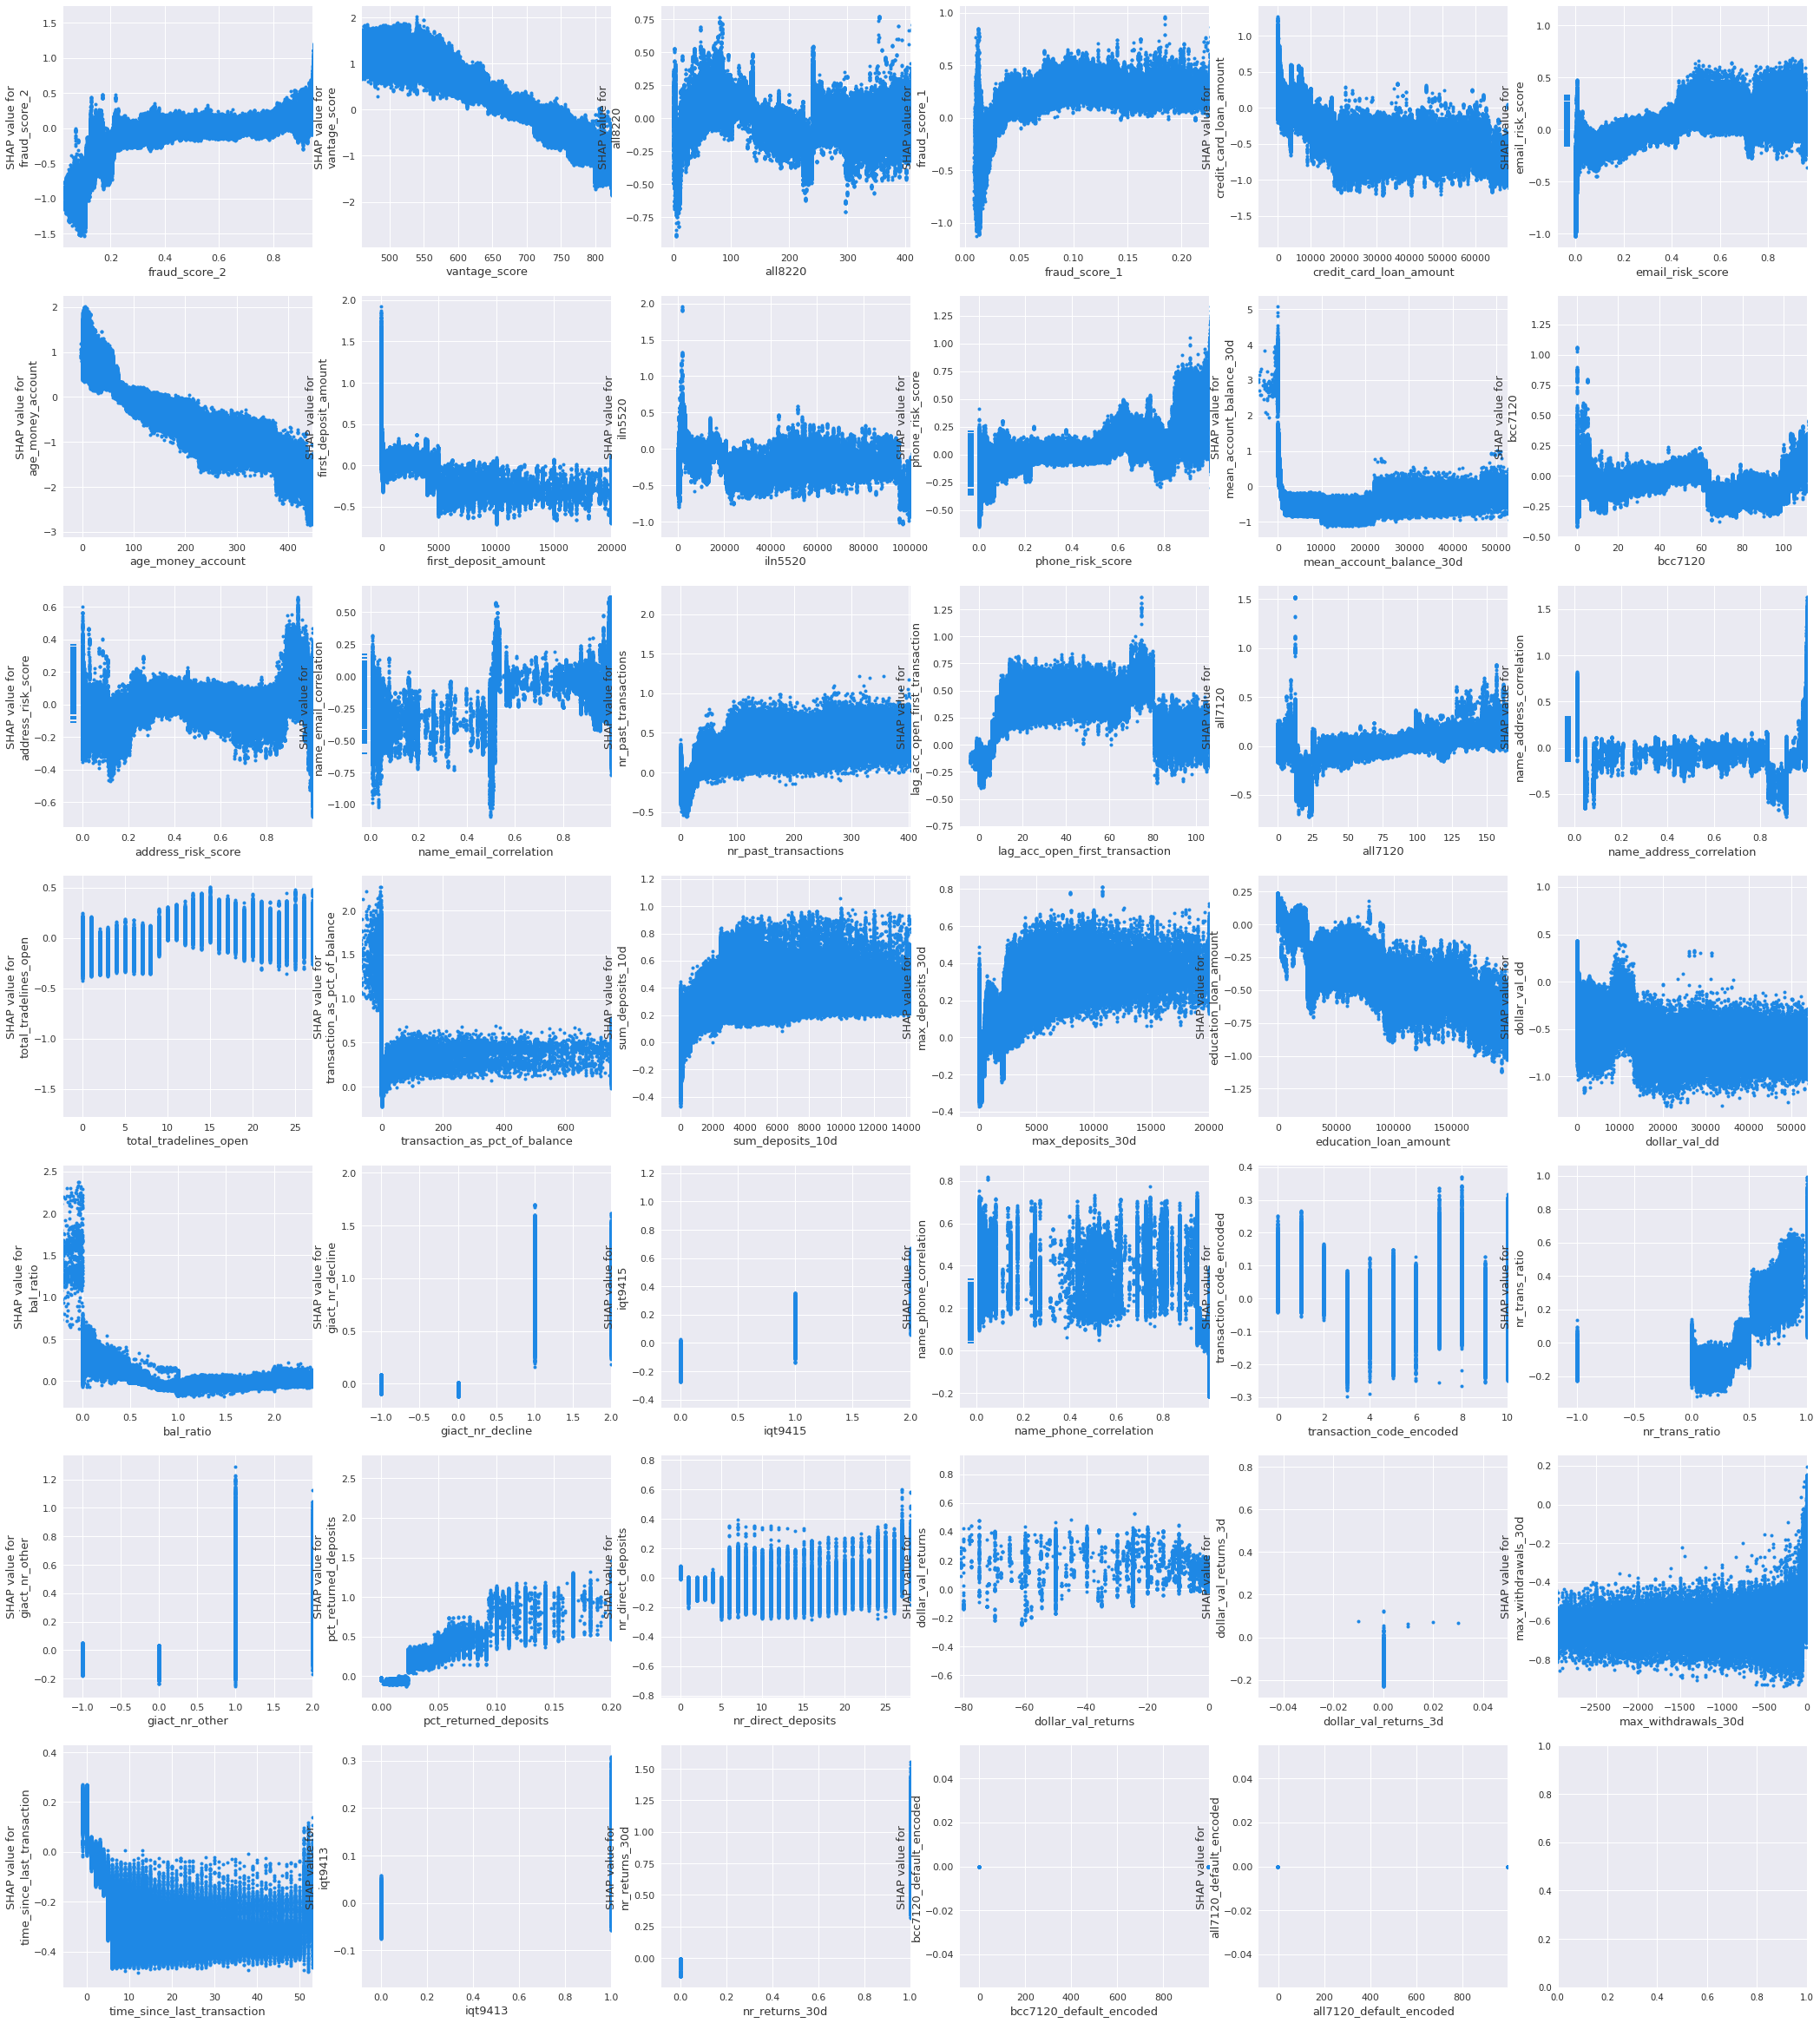

In [8]:
fig = get_shap_dependence(modeling_df[model.feature_name_], 
                          shap_values, features_by_imp, interaction_index=None)
fig.savefig('../../artifacts/governance/shap_values_customer.png')

### Let's look at the rows one by one
---
We can use numbers to indicate the depth needed to drill in:
* 0: makes sense. No effort needed.
* 1: mostly makes sense. Some special behavior
* 2: isn't clear. Need to go deep.

Couple ways to analyze each:
* shap interactive plots
* woe based on the provided bins
* my transaction visualizer
* ice plots
* lime and other local explanation methods, AIX or Interpret

In [9]:
def get_idx(L, l):
    return [L.index(e) for e in l]

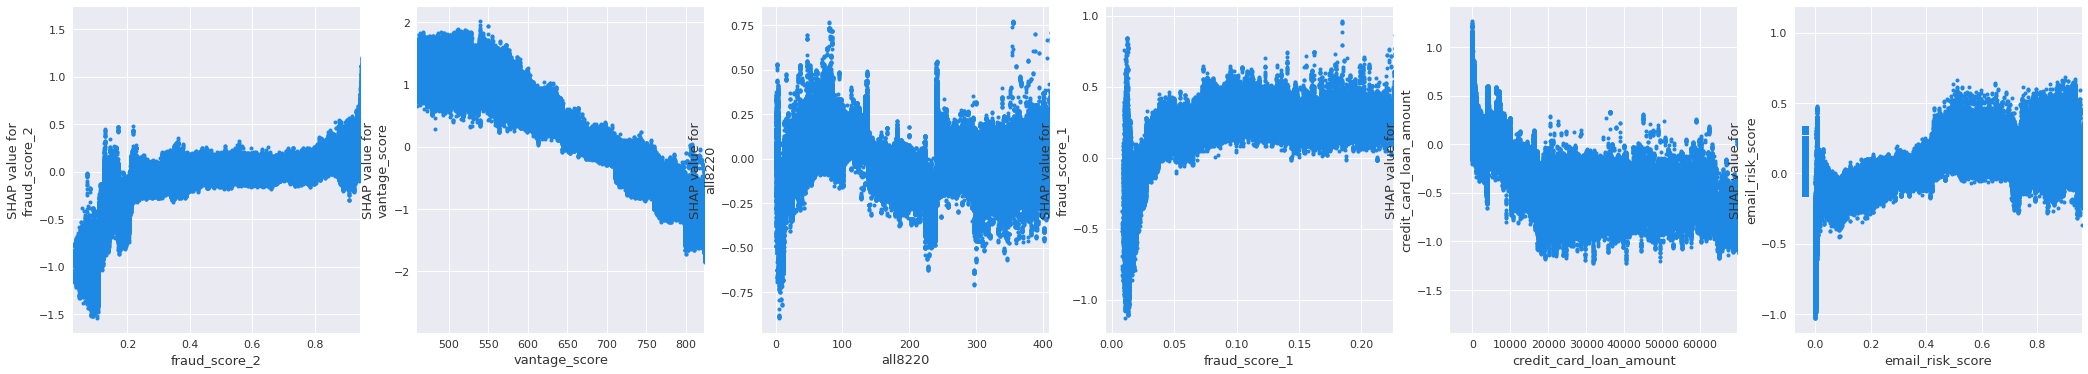

In [10]:
row = 0
features_sample = features_by_imp[row*6:row*6+6]
features_idx = get_idx(model.feature_name_, features_sample)
fig = get_shap_dependence(modeling_df[features_sample], 
                          shap_values[:, features_idx], 
                          features_sample, 
                          interaction_index=None)

* `fraud_score_2`: 0, risk increases as fraud score approaches 1
* `vantage_score`: 0, higher vantage score indicates lower risk
* `all8220`: 2, woe exhibits a downward trend, which correspond to the early all8220 values > 60 range. 
    * Number of months since the oldest trade was opened excluding collections including indeterminates
    * From 60 and on, the trend exhibits the behavior of the WOE of the plot, which is a downard trend.
    * By looking into the behaviors of this feature along with its peers, we observe many interaction effects which is shown (HERE).
* `fraud_score_1`: 1, some what of a mixed behavior. Makes sense that it trends up as fraud score 2, but curious what caused the initial decline in the beginning. 
    * makes sense as it trends up as value increases.
    * the shap dependence spans significnatly around 0. This may occur for two reasons:
        1. Since our target definition can be noisy, good users may be labeled as bad in some samples, contributing to the number of cases that drives up the BAD count at low fraud score.
        2. For real fraud accounts, some fraudsters would dedicate to mimic real users, that may end up with fraud_score_1 failing to capture the fraud attempt.
* `credit_card_loan`: 0, a downward trend corresponds to the WOE plot of this feature. Hypothesis: High credit card loan may indicate higher debt burden, but at the same time, the account may be more genuine and less likely to resemble first party fraud behavior. (To verify)
* `email_risk_score`: 0, makes sense. Higher email risk score led to higher risk. Most of the predictive power came in the near 0 range, which was able to isolate many good account.

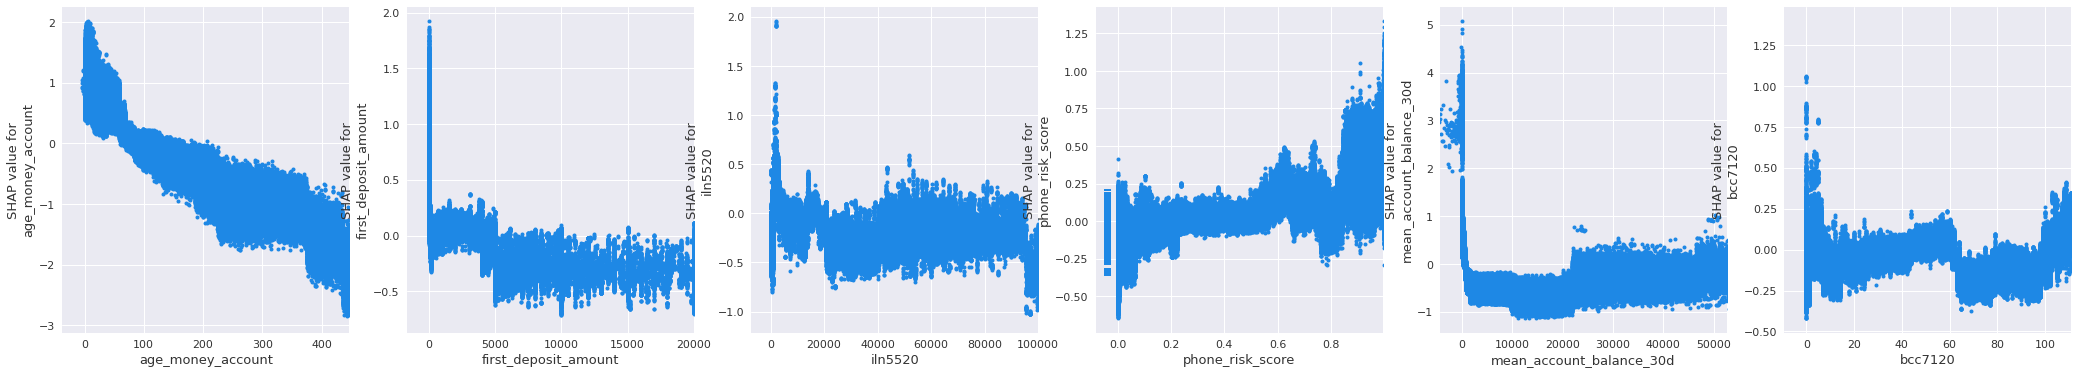

In [11]:
row = 1
features_sample = features_by_imp[row*6:row*6+6]
features_idx = get_idx(model.feature_name_, features_sample)
fig = get_shap_dependence(modeling_df[features_sample], 
                          shap_values[:, features_idx], 
                          features_sample, 
                          interaction_index=None)

* `age_money_account`: 0, longer the account be with us, less risky it is.
* `first_deposit_amount`: 0, most serious users probably deposit more funds at the beginning. 
* `iln5520`: 0, defn: average credit amount on open installment trades reported in the last 6 months with credit amount > 0
    * a downard trend corresponds to the WOE transformation
* `phone_risk_score`: 0, makes seense, good up-trend as higher risk score indicates higher fraud likelihood.
* `mean_account_balance_30d`: 0, most of the prodicative power lies in the extremely low account balance area, which makes sense.
* `bcc7120`: Max single balance to credit amount ratio on an open revolving bankcard trade reported in the last 6 months with credit amount > 0.
    * some thoughts: low -> infrequent large purchases and more consistent spending. High -> one purchase that lifts the feature.
    * risky as it approaches or crosses 100 - makes sense
    * near 0 value - either the account is recent or credit savvy spenders, that can go both ways.
    * We looked at the dependence plot w.r.t. a few selected features, and believe the "bump" is due to non-linear effect by employing multiple features.

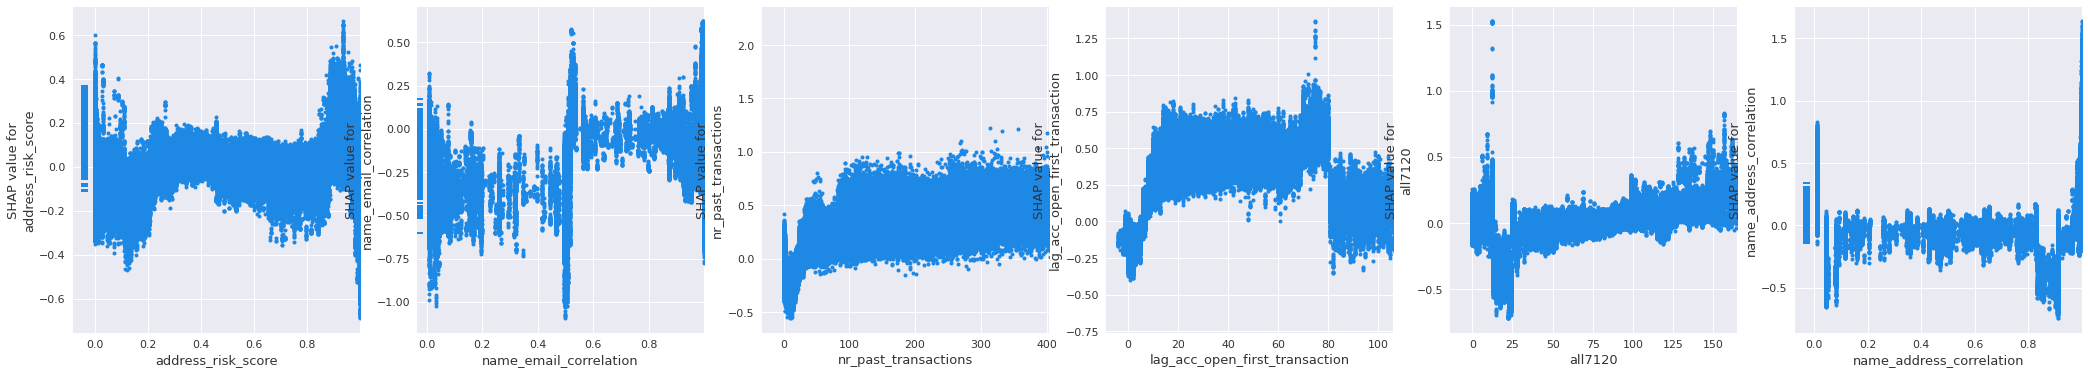

In [12]:
row = 2
features_sample = features_by_imp[row*6:row*6+6]
features_idx = get_idx(model.feature_name_, features_sample)
fig = get_shap_dependence(modeling_df[features_sample], 
                          shap_values[:, features_idx], 
                          features_sample, 
                          interaction_index=None)

* `address_risk_score`: 1, interesting as we see the twist and turnes...but the general trend is upward.
    * We generally 
* `name_email_correlation`: 2, there is a looooooose uptrend in there, but it seems like the key to this feature was simply separating the feature into groups. Definitely look at the interaction effects.
* `nr_past_transactions`: 2, loose uptrend. Original thought is this should be similar to `age_money_account` which exhibits a downward trend, as more active users tend to exhibit less risky behaviors. To investigate:
    * which kind of BAD definition is more correlated to this feature. One potential explaination was that: high utility accounts tend to go accidentally negative, but for extended times...or for multiple times
    * also, interaction effects.
* `lag_acc_open_first_transaction`: 
    * 1, good uptrend < 80, longer the wait, higher the risk. 
    * it drops to near 0 after 80, which is interesting. We found many data with`all8220` > 250 fall in that range, where as high number of months since the last trade was openned. This  indicate the group of users that opens an account but for some reason (maybe forgot) did not make use of it or create new ones. This can be a frequent behavior for customers with multiple credit lines, and unlikely for fraudsters. As the result, the combination of these two features have the tendency to drive down the predicted riskiness.
* `all7120`: 
    * 2. Number of months since the oldest trade was opened excluding collections including indeterminates
    * corresponds with WOE, an upward trend.
    * it makes business sense such that credit account has less history may fall into the high risk group, as the account may be opened specifically for fraud purposes. 
* `name_address_correlation`: 0, It makes sense as the correlation indicates high risk at the ends of this feature. Most fraudsters will either use fake identity that does not correlate with the address, or curate their profile detailed enough trying to appear legitemate. Everyone else falls in the middle that does not appear to push the predictions toward one direction or the other.

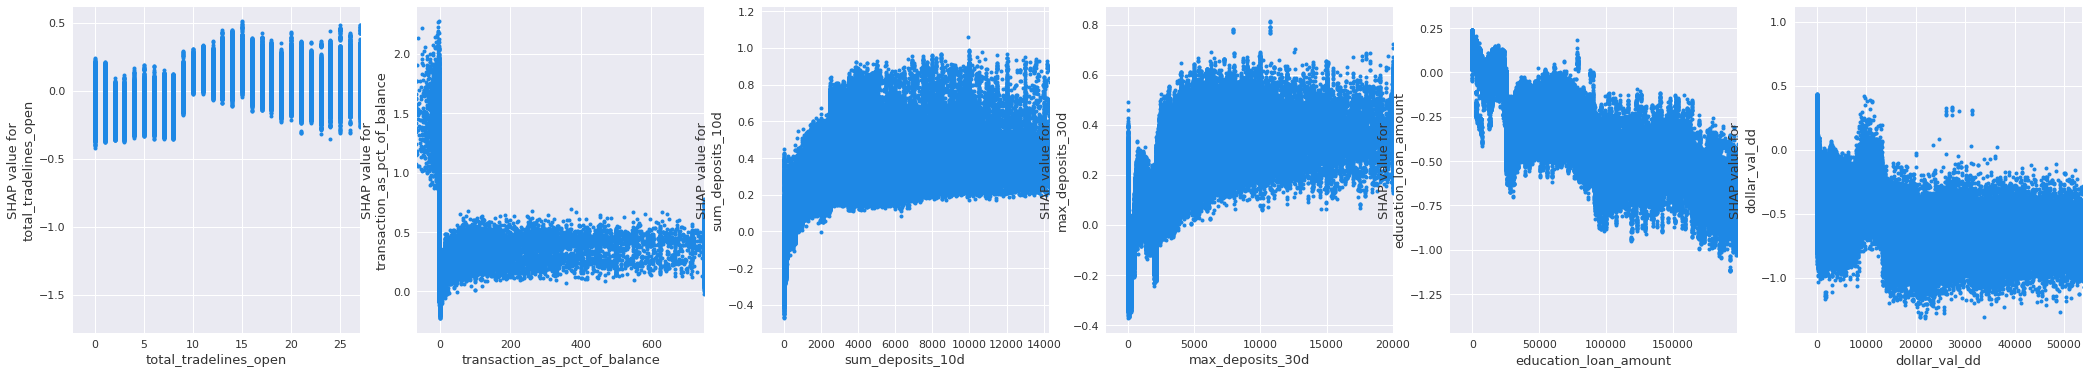

In [13]:
row = 3
features_sample = features_by_imp[row*6:row*6+6]
features_idx = get_idx(model.feature_name_, features_sample)
fig = get_shap_dependence(modeling_df[features_sample], 
                          shap_values[:, features_idx], 
                          features_sample, 
                          interaction_index=None)

* `total_tradelines_open`: 0, a clear downard trend, corresponds to the behavior of WOE. While having a total tradelines open count less than 35 does not drive the prediction toward one direction, having a large number of tradelines resembles lead to a credit utilized customer. If they do not exhibit good credit history and behavior, it is very unlikely they would have as much tradelines open.
* `transaction_as_pct_of_balance`: 0, makes sense. when it turns negative it means they are spending the money they don't have.
* `sum_deposits_10d`: 0, if someone try to pull something fraudulous, they probably go for a reasonable dollar value. An total amount less than 2000 I guess is not very enticing.
* `max_deposits_30d`: 0, same logic as `sum_deposits_10d`.
* `education_load_amount`: 0, higher education loan means the person is more educationally/long-term-ly invested, less likely to carry out fraudulent behaviors.
* `dollar_val_dd`: 0, `transaction code == ACHINDD`, if this means ach push, that probably means user initiated push
    * clear downward trend. A higher dollar amount leads to lower risk becuase the customer is showing sincerety by initiating ACH push, with no risk of default.
    * we do see significant interaction behavior with this features, as shown in the plots with features: `vantage_score, age_money_account, nr_direct_deposits`

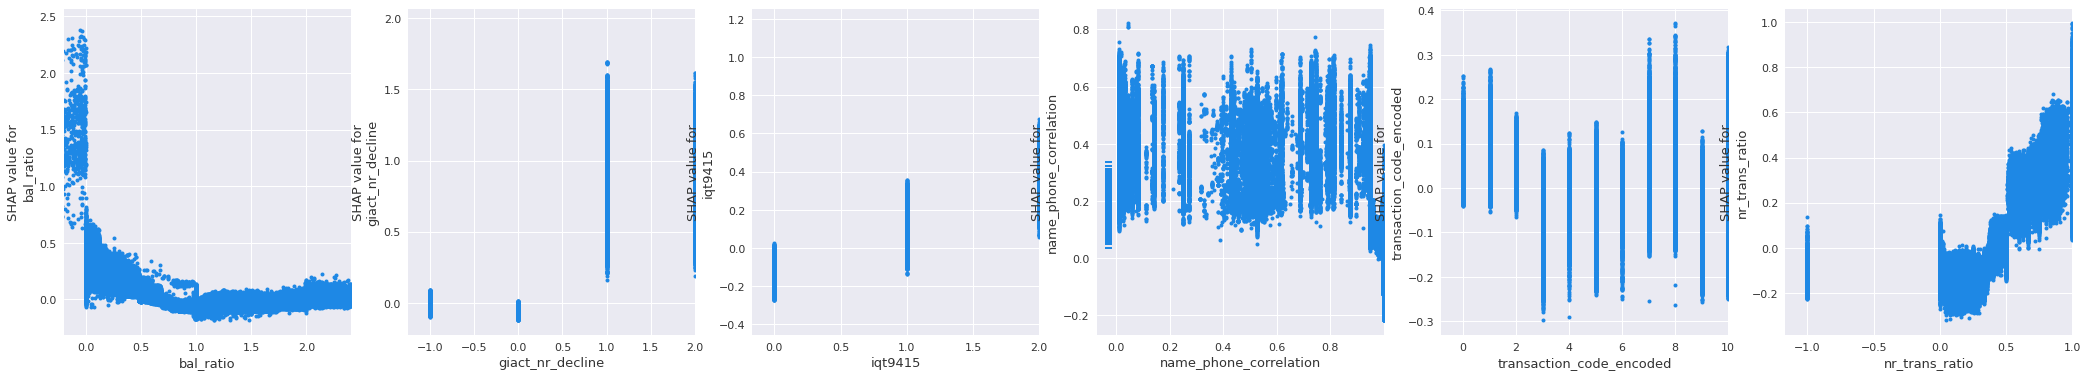

In [14]:
row = 4
features_sample = features_by_imp[row*6:row*6+6]
features_idx = get_idx(model.feature_name_, features_sample)
fig = get_shap_dependence(modeling_df[features_sample], 
                          shap_values[:, features_idx], 
                          features_sample, 
                          interaction_index=None)

* `bal_ratio`: 0, `mean_account_balance_3d/mean_account_balance_30d`, a low value indicates severe spending acceleration. Like `transaction_as_pct_of_balance`, just in a longer time frame.
* `giact_nr_decline`: 0, yeah, decline means bad behavior.
* `iqt9415`: 
    * Total number of inquiries made in that last 30 days. 
    * Make sense, more inquires made, the more risky as fraudsters.
* `name_phone_correlation`: 
    * significant amount of interactive behaviors: vantage_score, email_risk_score, phone_risk_score.
    * seeing a downard trend toward the end, as high correlation indicates lower risk.
* `transaction_code_encoded`: 
    * plot code along side with the shap dependency plot
    * Make sense, safer transaction code like `ACHINDD`, `ACHDDIN` are lower risk and transaction types like `POSDW` leads to riskier behaviors.  The rest are somewhat balanced, not exhbiting upward or downward affecting forces to the model prediction.
* `nr_trans_ratio`: 0, `nr_transactions_3d/nr_transactions_30d`, lower value means consistent spending, which is less risky. higher value means spending spurt that tend to correlate with high risk behaviors.

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.


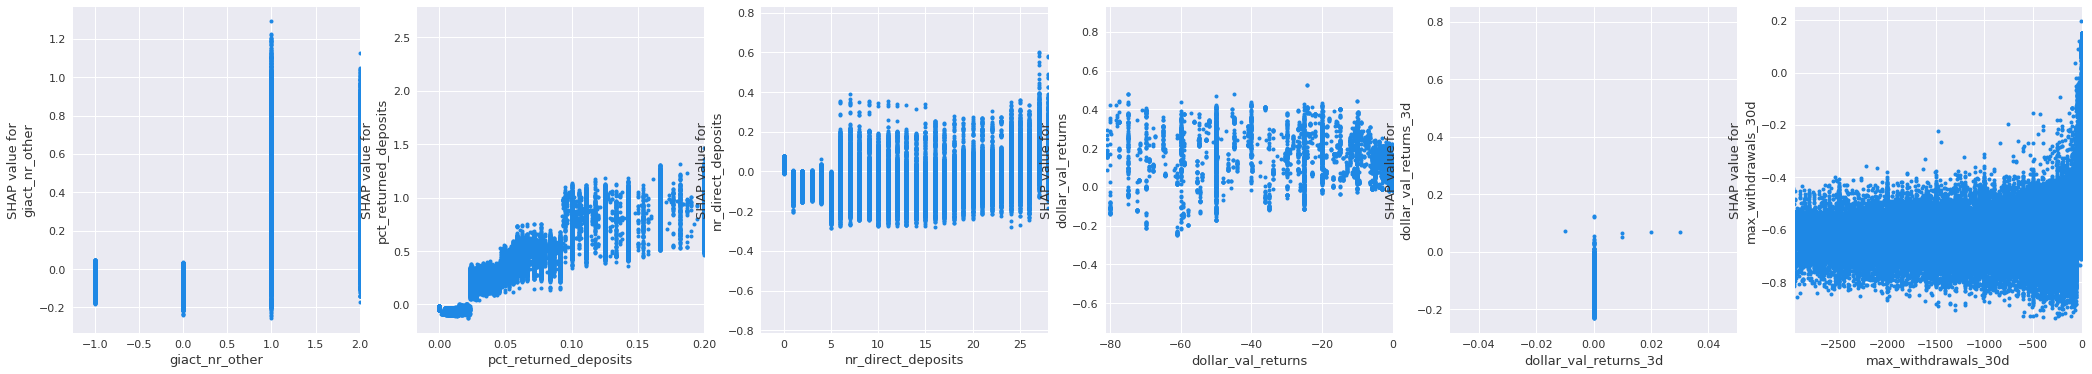

In [15]:
row = 5
features_sample = features_by_imp[row*6:row*6+6]
features_idx = get_idx(model.feature_name_, features_sample)
fig = get_shap_dependence(modeling_df[features_sample], 
                          shap_values[:, features_idx], 
                          features_sample, 
                          interaction_index=None)

* `giact_nr_other`: corresponds to WOE, which exhibits an upward trend.
* `pct_returned_deposits`: 0, more past returns mean higher risk.
* `nr_direct_deposits`: * corresponds with WOE. more direct deposits indicates customer's sincerity, indicates lower risk.
* `dollar_val_returns`: See deatils in 4.3
* `dollar_val_returns_3d`: See details in 4.3
* `max_withdrawals_30d`: During preprocessing, we purposefully assigned withdraws to have negative sign, and max_withdraws represents the maximum in terms of absolute dollar value. The SHAP dependency plot exhibits a trend that corresponds with WOE. We believe this is because right before fraudulent behaviors, it is typical for fraudsters to initiate a small withdraw to ensure the account is functional. 

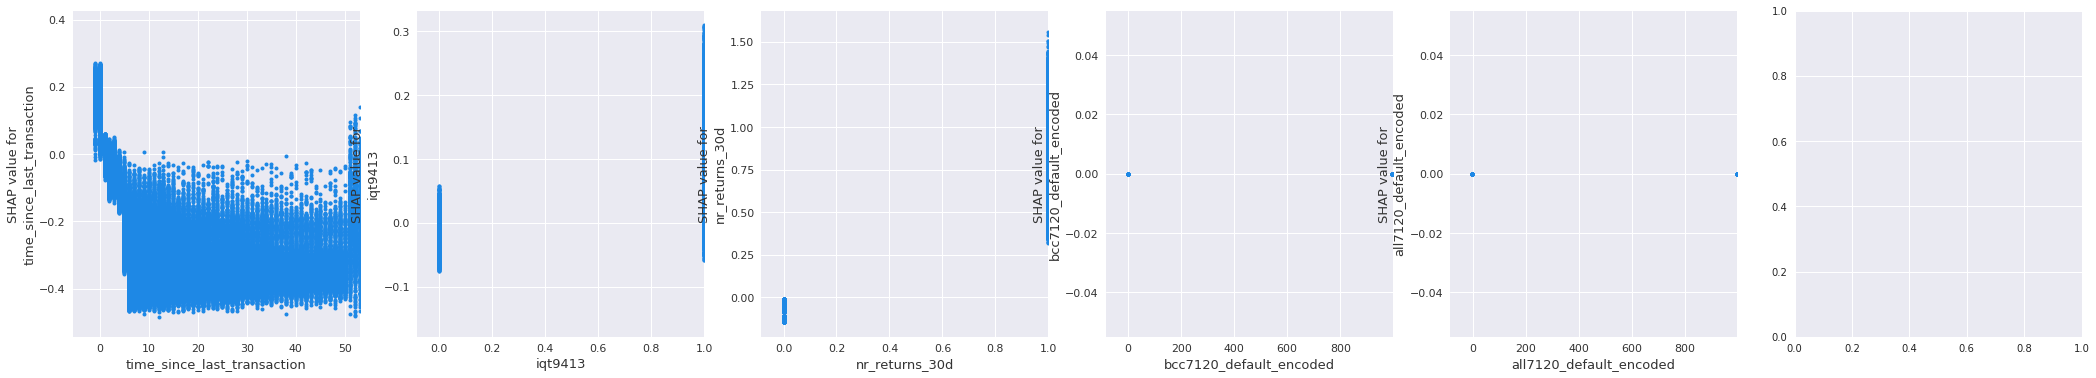

In [16]:
row = 6
features_sample = features_by_imp[row*6:row*6+6]
features_idx = get_idx(model.feature_name_, features_sample)
fig = get_shap_dependence(modeling_df[features_sample], 
                          shap_values[:, features_idx], 
                          features_sample, 
                          interaction_index=None)

* `time_since_last_transaction`: 
    * for the most part exhibits a downward trend just as WOE. 
    * for the tick up on the right, we believe it can be attributed to the combined effect of other features, as shown here `vantage_score`, `nr_trans_ratio`, and `name_email_correlation`, `bal_ratio`
* `iqt9413`:
    * 2, Total number of inquires made in the last 30 days.
    * an upward trend, corresponds to WOE also with intuition, as more inquries leads to attempts to open accounts and high-risk behaviors.
* `nr_returns_30d`: 0, high past returns, high risk.